In [1]:
import numpy as np
import eit
from eit import pol2cart, cart2pol
import bayesian_design as bd
import matplotlib.pyplot as plt
import itertools
import GPyOpt
from scipy.optimize import minimize_scalar, minimize
import autograd
from autograd import numpy as np
import os
%matplotlib inline

In [2]:
from IPython.core.magic import register_cell_magic
@register_cell_magic
def capture_cell(line, cell):
    globals()[line.strip()] = cell
    exec(cell, globals())

In [3]:
scale = 1000
amps = 0.2
kernel_variance_mult = 1.0
ls = 0.3
output_dir = 'dummy_data'

fun_args = np.array([ls, kernel_variance_mult])

In [4]:
function_dest = os.path.join(output_dir, 'function.py')

In [5]:
# load in observational data

current_file = np.loadtxt('RPI_2d_chest_phantom_data/ssout1.dat')

currents = np.empty((31, 32))
for i in range(len(current_file) / 32):
    this_currents = current_file[32*i:32*(i+1)]
    currents[i] = this_currents

In [6]:
# code for setting up the stim pattern
stim_pattern = currents*amps*scale
meas_pattern = np.eye(32)
pattern = eit.grids.EITPattern(meas_pattern, stim_pattern)

In [7]:
design = eit.grids.construct_circular(10, 64, 32)
print len(design.all)

411


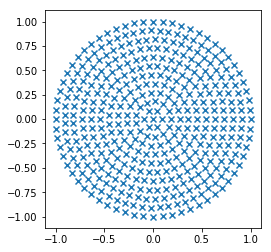

In [8]:
plt.scatter(design.all[:,0], design.all[:,1], marker='x')
plt.gca().set_aspect('equal')

In [9]:
%%capture_cell function
centers = [(0.4, 0.4), (-0.4, -0.4)]
width = 0.3
def field_fun(x, y, centers, ls):
    ret = 1.
    for c in centers:
        ret = ret + np.exp(-((x - c[0])**2 + (y - c[1])**2) / ls**2)
    return ret

field_fun_x = autograd.elementwise_grad(field_fun)
field_fun_y = autograd.elementwise_grad(field_fun, 1)

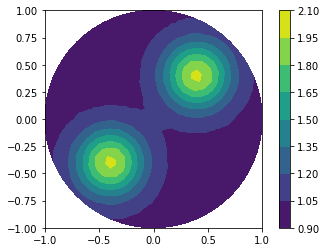

In [10]:
test_field = field_fun(design.all[:,0], design.all[:,1], centers, width)
plt.tricontourf(design.all[:,0], design.all[:,1], test_field)
plt.gca().set_aspect('equal')
plt.colorbar()

In [11]:
def get_cov(test_points, interior, sensors, fun_args):
    def get_field(fun, x):
        return fun(x[:,0], x[:,1], centers, width)
    theta_int = get_field(field_fun, interior)
    theta_int_x = get_field(field_fun_x, interior)
    theta_int_y = get_field(field_fun_y, interior)
    theta_sens = get_field(field_fun, sensors)
    
    test_points_aug = np.c_[test_points, np.empty((len(test_points), 3))]
    interior_aug = np.c_[interior, theta_int, theta_int_x, theta_int_y]
    sensors_aug = np.c_[sensors, theta_sens]
    
    mu_mult, cov = eit.collocate.collocate_no_obs(np.asfortranarray(test_points_aug), 
                                            np.asfortranarray(interior_aug), 
                                            np.asfortranarray(sensors_aug), 
                                            np.asfortranarray(fun_args))
    return mu_mult, cov

In [12]:
mu_mult, cov = get_cov(design.sensors, design.interior_plus_boundary, design.sensors, fun_args)

In [13]:
measured = np.dot(meas_pattern, mu_mult)
measurements = []
for row in stim_pattern:
    rhs = np.concatenate([np.zeros(len(design.interior_plus_boundary)), row])
    meas = np.dot(mu_mult, rhs)
    measurements.append(meas)
measurements = np.row_stack(measurements)

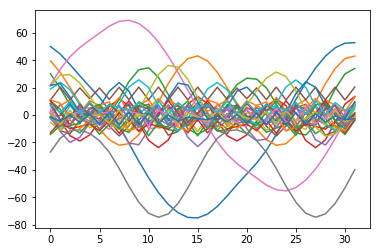

In [14]:
plt.plot(measurements.T);

In [15]:
# need to add a dummy entry to the beginning
dummy_voltages = np.concatenate([[amps], measurements.ravel()])

In [16]:
np.savetxt(os.path.join(output_dir, 'voltages.txt'), dummy_voltages)
np.savetxt(os.path.join(output_dir, 'currents.txt'), current_file)
with open(os.path.join(output_dir, 'function.py'), 'w') as f:
    f.write(function)